In [ ]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import silhouette_score

%matplotlib inline

## K-Means

K-Means is an unsupervised ML algorithm. **Unsupervised ML** does not have "truth labels" for a model to learn. Rather, we use these algorithms to find what we call "latent structure" in our data. The most common form of "structure" we're looking for is groups (aka, clusters).

K-means is one of the most simple clustering algorithms out there. It has 4 steps:

1. Randomly (or, in order to make convergence quicker, cleverly) choose K centroids in the feature space
2. Assign each data point to the centroid/cluster closest to it
3. Recalculate each centroid by taking the mean (for each predictor) of all the data points in each cluster.
4. Repeat Steps 2 and 3 until convergence
    - either cluster assignments don't change from step to step OR
    - the centroid doesn't change much from step to step

<img src="https://drive.google.com/uc?export=view&id=1RHRfcPIjIZ_-IMOE00gyzVadlaGxXPh8" width=350px />

One thing to keep in mind with K-Means is that is assumes *spherical* variance within each cluster. That means that K-means behaves as if--within each cluster--all predictors have the same variance. Roughly, this means that we could easily draw a sphere (or circle) around each of our clusters, even if it's not perfectly spherical.

### K-Means Math

When building clusters in K-means, we're trying to choose cluster **assignments** and cluster **centers** that minimize the *distortion* (aka the [inertia](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html): Sum of Squared Distances of samples to their closest cluster center).

$$ \underbrace{J}_\text{distortion} = \sum_{\color{Red}n=1}^{N}\sum_{\color{Blue}k=1}^{K} {\color{Purple} r}_{{\color{Red} n}{\color{Blue} k}}  \left\| x_{\color{Red}n} - \mu_{\color{Blue}k} \right\|^2 $$

In K-means, we have **hard assignment** meaning data points can only belong to a single cluster, so all ${\color{Purple} r}_{{\color{Red} n}{\color{Blue} k}}$ are `0` or `1` (you either don't belong, or do belong to a cluster).

$$ {\color{Purple} r}_{{\color{Red} n}{\color{Blue} k}}=\begin{cases}
      1 & \text{if $\hspace{0.2in}{\color{Blue} k} = $ arg min$_{\color{Teal}j}$ $\left\|x_{\color{Red}n} - \mu_{\color{Teal}j} \right\|^2$}\\
      0 & \text{otherwise}
\end{cases}  
$$

Just like with *anything* in this class, if we have a function we want to optimize (in this case minimize), we can do so by taking it's derivatives, setting them to 0, and solving to get the best possible parameters (e.g. the cluster centers, $\mu_k$).

## K-Means++
The inital cluster centers chosen in step 1 above can have a big impact on the final clusters that K-Means returns. To overcome this, one proposed solution is **K-means++** which initializes cluster centers in a smart way:

- randomly select the first cluster center by randomly selecting a single data point
- for each data point, calculate the distance between it and the closest centroid
- randomly select another cluster center so that points *furthest away* from the current centroids have the highest probability of being selected
- repeat this process until $k$ cluster centers have been chosen


By choosing cluster centers (centroids) far away from each other, we're most likely to get points that are a part of different clusters.

## Super vs. Unsuper
K-Means is our first clustering algorithm. Clustering is *unsupervised machine learning*. Based on the definition of *supervised machine learning* we talked about before, what makes k-means unsupervised?

### Supervised ML
Notice in the above code, our workflow is broadly:

1. load in data, create X's and y's (including model validation)
2. Create Empty Model + Pipeline
3. Fit your model
4. Assess your model (using `.predict()` + some performance metric)


### Unsupervised ML
In Unsupervised ML, we don't HAVE the "correct answers" for our model. Unsupervised ML focuses on finding underlying *structure* in the data, e.g. clusters. There's no "right" answer for these models.

Because there isn't a "right" answer for us to compare our results to, we usually don't worry about Model Validation, nor do we care about data leakage. So our workflow is a little simpler.

1. load in our data
2. Create Empty Model + Pipeline
3. Fit your Model
4. Assess your model (using `.predict()`/`labels_` and by looking at plots, or something like a silhouette score)


0.3111090023669229


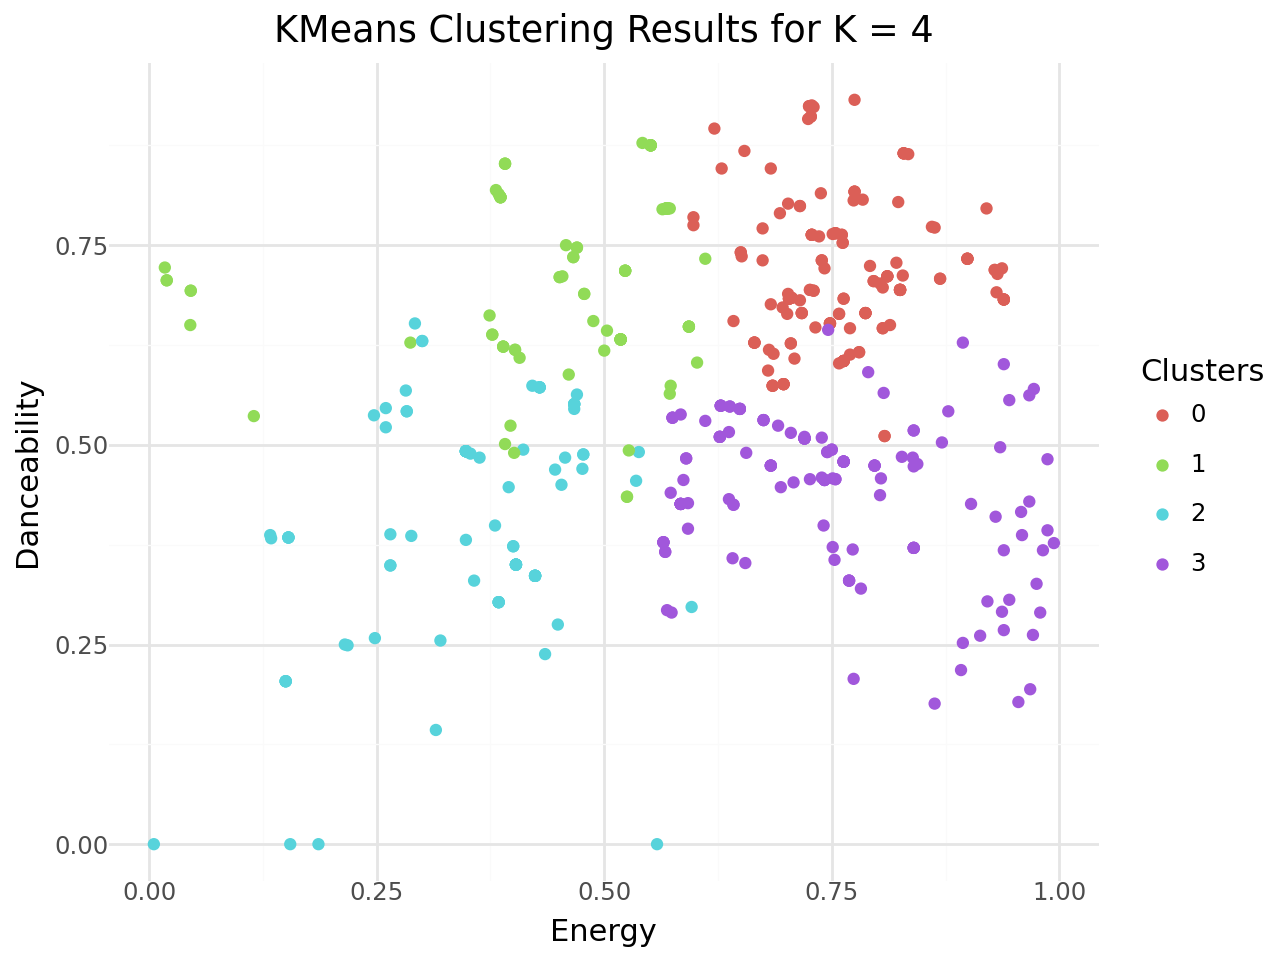

In [ ]:
#### STEP 1. ####
bey = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/Beyonce_data.csv")
bey.head()

predictors = ["energy", "danceability", "valence"]


X = bey[predictors]

#### STEP 2. ####
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

#### STEP 3. ####
km = KMeans(n_clusters = 4)
pipe = Pipeline([("z", z), ("clust", km)])

#### STEP 4. ####
labels = pipe.fit_predict(X)

#### STEP 5. ####
print(silhouette_score(X, pipe.predict(X)))
X["clusters"] = labels

(ggplot(X, aes(x = "energy", y = "danceability", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Energy", y = "Danceability", title = "KMeans Clustering Results for K = 4",
         color = "Clusters"))



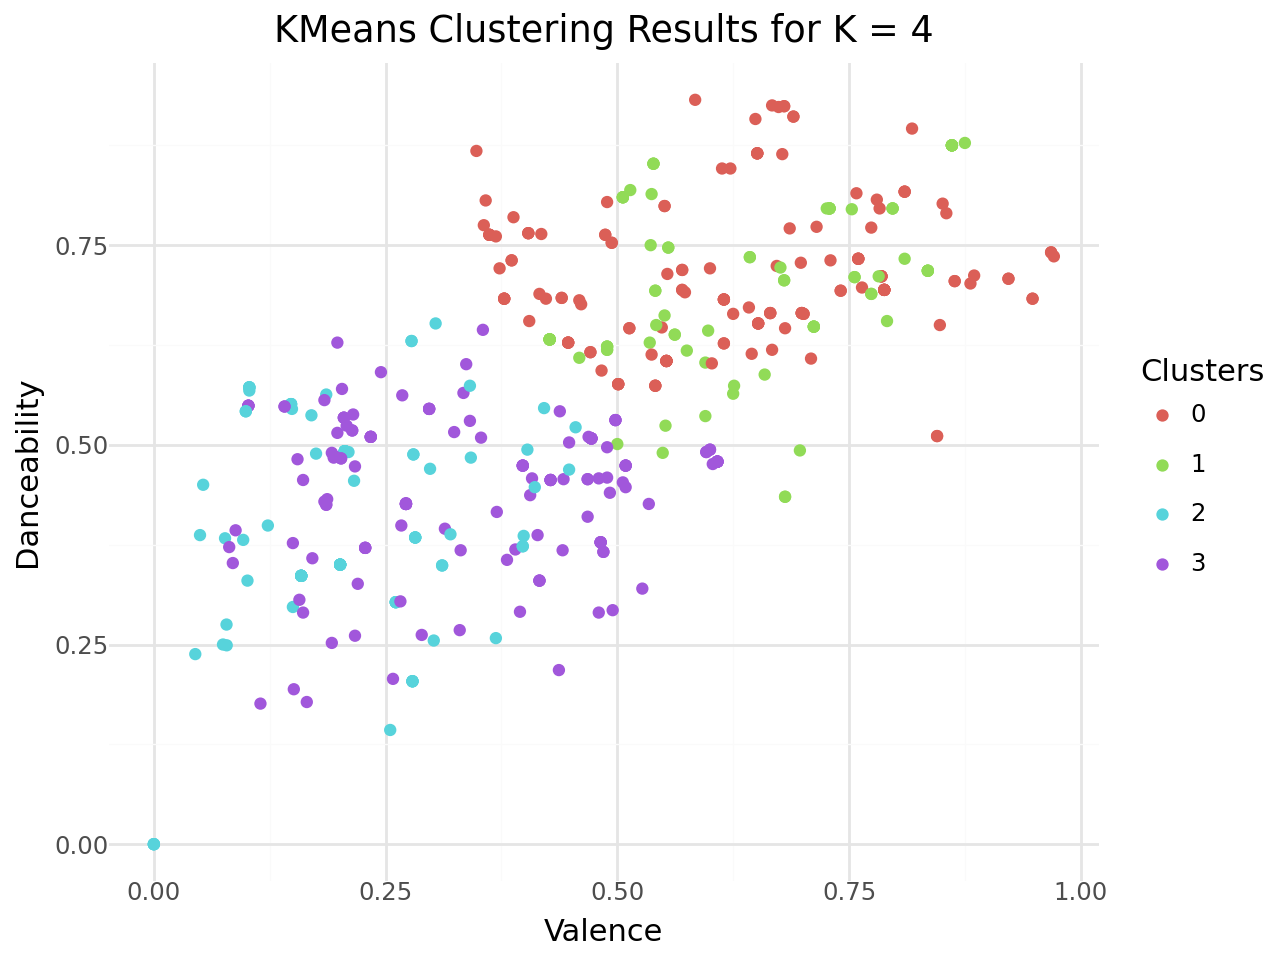

In [ ]:
(ggplot(X, aes(x = "valence", y = "danceability", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Valence", y = "Danceability", title = "KMeans Clustering Results for K = 4",
         color = "Clusters"))

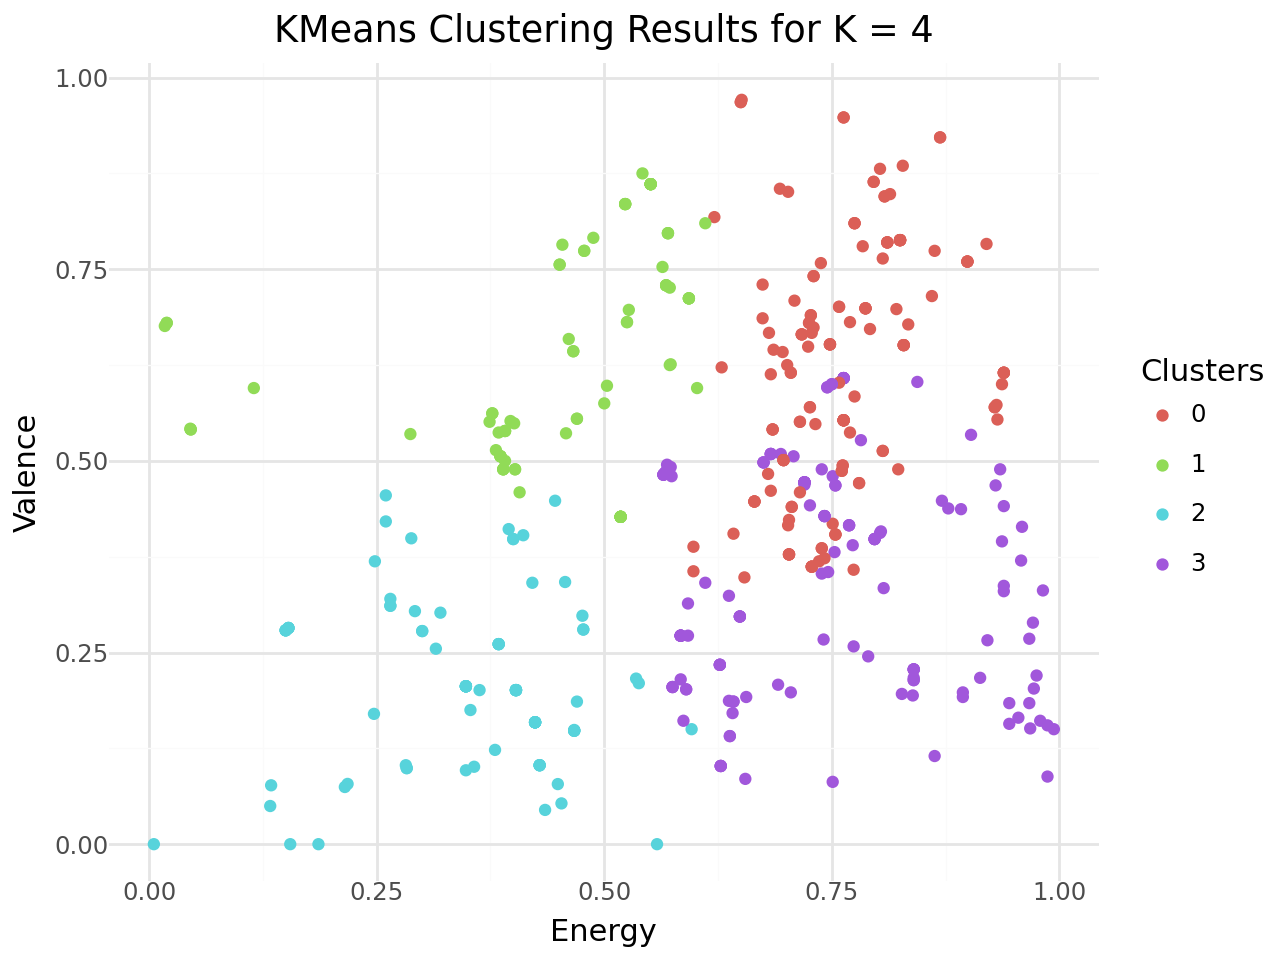

In [ ]:
(ggplot(X, aes(x = "energy", y = "valence", color = "factor(clusters)" )) +
      geom_point() + theme_minimal() +
     labs(x = "Energy", y = "Valence", title = "KMeans Clustering Results for K = 4",
         color = "Clusters"))


Notice that Model Validation isn't a part of our workflow anymore. Also notice that there are no `y` variables. When we `.fit()`, we only give it an `X`! This is all because KMeans is an *unsupervised* ML Algorithm.

### Another Example (choosing `k` using the data)

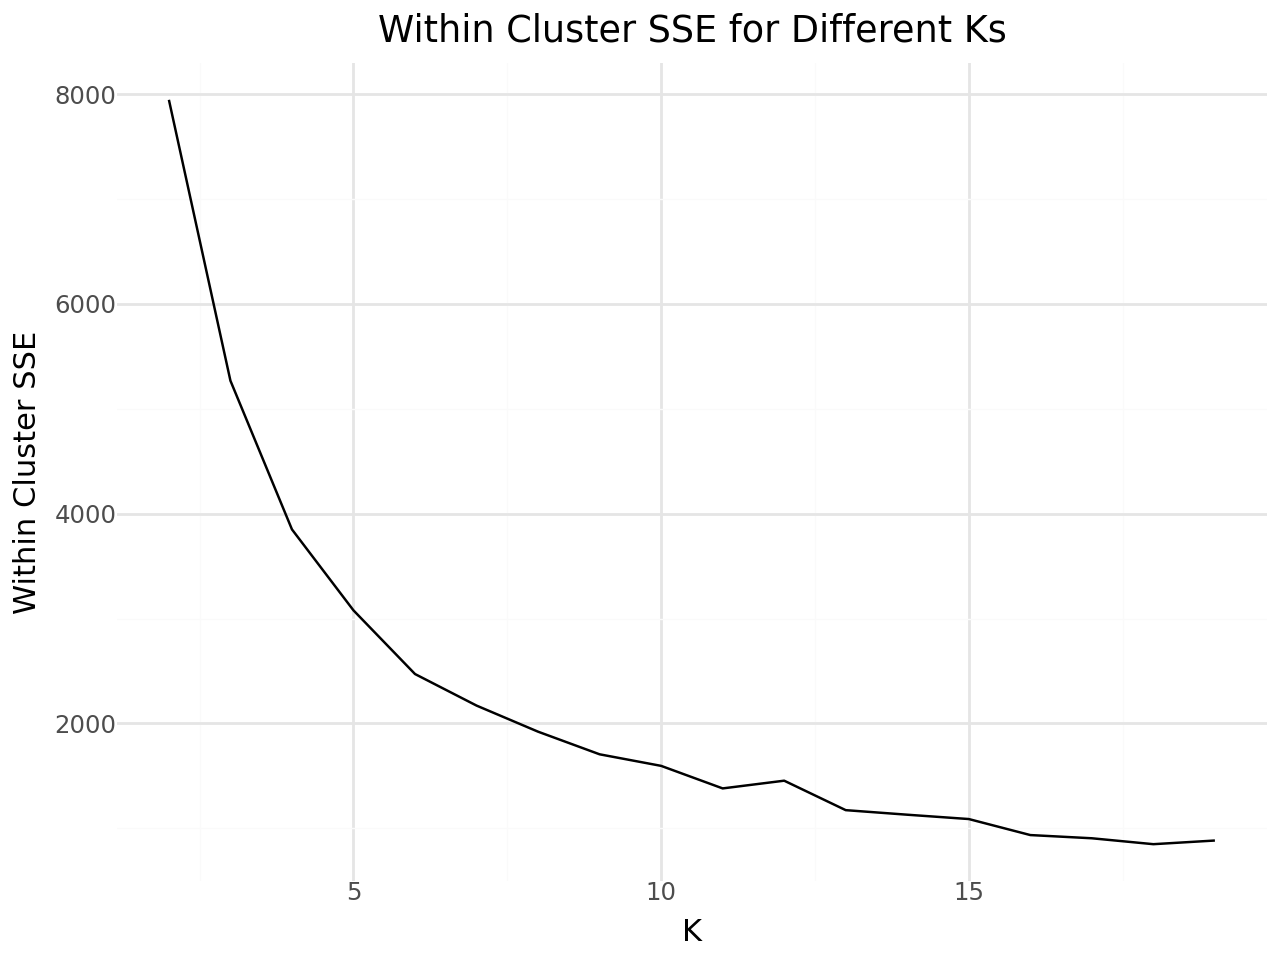

In [ ]:
wine = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/wineLARGE.csv")

# drop and reset rows
wine.dropna(inplace = True)
wine.reset_index(inplace = True)

# grab data we want to cluster
feats = ["citric.acid", "residual.sugar"]

X = wine[feats]

# create empty model
z = make_column_transformer((StandardScaler(), feats),
                            remainder = "passthrough")

metrics = {"SSE": [], "sil": [], "k": []}

for i in range(2,20):
    km = KMeans(i)
    pipe = Pipeline([
        ("pre", z),
        ("km", km)
    ])

    labels = pipe.fit_predict(X[feats])
    sil = silhouette_score(X[feats], labels)
    sse = pipe.named_steps["km"].inertia_

    metrics["SSE"].append(sse)
    metrics["sil"].append(sil)
    metrics["k"].append(i)

df = pd.DataFrame(metrics)

(ggplot(df, aes(x = "k", y = "SSE")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Within Cluster SSE",
         title = "Within Cluster SSE for Different Ks"))




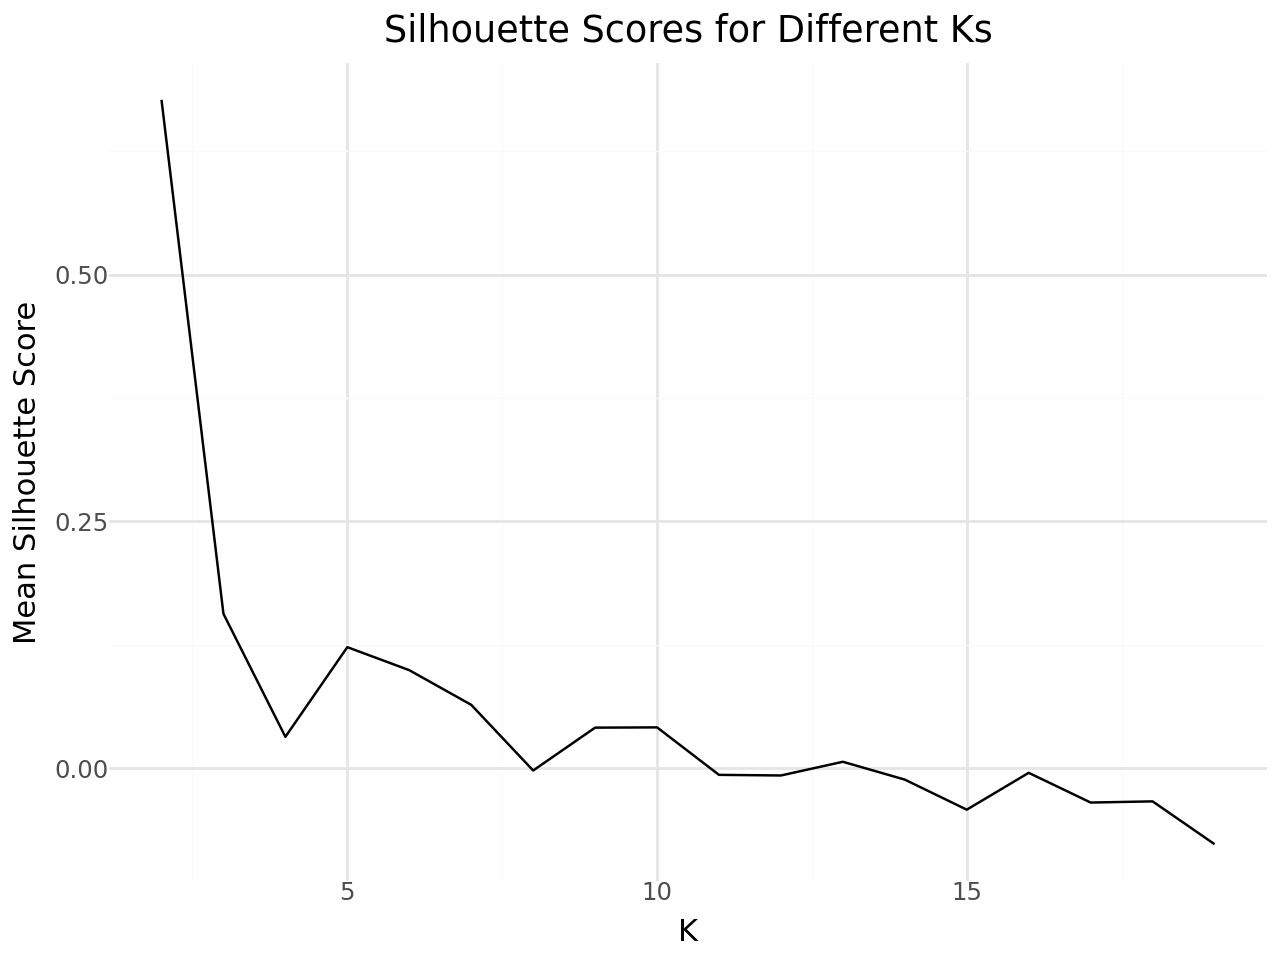

In [ ]:
(ggplot(df, aes(x = "k", y = "sil")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Mean Silhouette Score",
         title = "Silhouette Scores for Different Ks"))

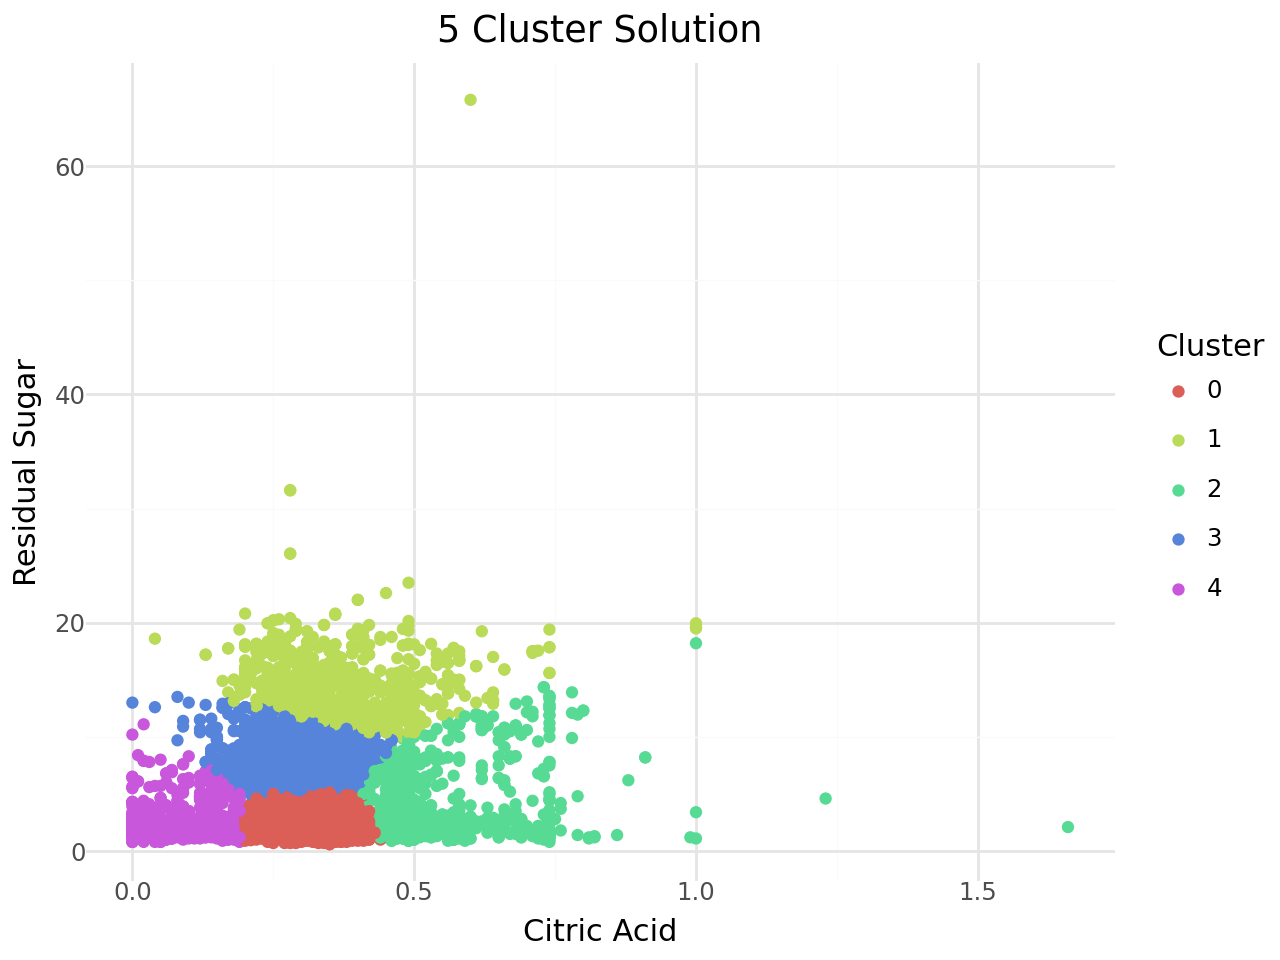

In [ ]:
km = KMeans(5)
pipe = Pipeline([
      ("pre", z),
      ("km", km)
])
labels = pipe.fit_predict(X)

X["cluster"] = labels
(ggplot(X, aes(x = "citric.acid", y = "residual.sugar", color = "factor(cluster)")) +
      geom_point() +
      theme_minimal() +
      scale_color_discrete(name = "Cluster") +
      labs(x = "Citric Acid",
           y = "Residual Sugar",
           title = "5 Cluster Solution"))

# Classwork

## K-Means from Scratch

Let's write our own simplified K-means function. Your function, `KM()` should take in two arguments:

- `df` a dataframe with all of your data.
- `k` the number of clusters to fit.

and apply K-Means to it. Remember that the steps of K means are:

**1**. DONE FOR YOU. Randomly select k centroids.
- I recommend choosing `k` random data points from `df`. You can do this by using `np.random.choice(range(0,df.shape[0]), k)` to select the indices for `k` randomly selected rows. THEN use those indices to grab the chosen rows from df and store them.
    
**2**. Assign each data point from `df` to the closest centroid.
- You'll need to calculate the distance between each data point and each centroid. Perhaps look at the KNN classwork to see how to do that using `np.linalg.norm()` (see Hint 3).
    - I recommend storing cluster/centroid membership by having a dictionary with one key for each cluster/centroid, and the value is a list of row indices pertaining to the data points in each cluster (see HINT 1 for an example of this)
    
**3**. Re-calculate the cluster mean/centroid
- For each centroid/cluster, find the mean value for each predictor/feature by taking the mean for that feature from all the data points assigned to the centroid/cluster.(see Hint 2)
    
**4**. DONE FOR YOU. Repeat Steps 2-3 until the change in centroid positions are all less than 0.0001
- in other words, calculate how far each centroid moved. If all of them moved less than 0.0001 units, then stop.
    
**5**. DONE FOR YOU. Return the cluster assignments by returning the dictonary of the clusters and their memberships that you create in #2.

### HINT 1:

You can store your cluster memberships like this (in this case k = 3, and there are only 20 datapoints, but your function should take any k, and any number of data points):

```
clust = {0: [0,7,4,5,12,18,20],
         1: [10,8,3,2,14,17,19],
         2: [1,6,7,9,11,13,15,16]}
```
      

### HINT 2:

If a cluster contained the following data points:

|           | X1 | X2 | X3 |
|-----------|----|----|----|
| Person 1  | 5  | 2  | 9  |
| Person 2  | 2  | 3  | 2  |
| Person 3  | 1  | 6  | 1  |
| Person 4  | 7  | 1  | 4  |
| Person 5  | 3  | 2  | 5  |
| Person 6  | 1  | 1  | 8  |
| Person 7  | 7  | 0  | 6  |
| Person 8  | 0  | 7  | 2  |
| Person 9  | 2  | 3  | 7  |
| Person 10 | 4  | 6  | 1  |


Then the centroid for that cluster would be [a,b,c] where a, b, and c are the means of each column X1, X2, and X3:

a = (5 + 2 + 1 + 7 + 3 + 1 + 7 + 0 + 2 + 4)/10

b = (2 + 3 + 6 + 1 + 2 + 1 + 0 + 7 + 3 + 6)/10

c = (9 + 2 + 1 + 4 + 5 + 8 + 6 + 2 + 7 + 1)/10




### HINT 3:

To calculate the distance between two vectors, you can use:

```
distance_ab = np.linalg.norm(a-b)

```

where `a` and `b` are the two vectors.

### HINT 4:

The `np.argmin()` function takes in a list (or array) of values, and returns the *index* of the smallest one.

For example:

```
my_list = [1,6,2,5,0]

np.argmin(my_list)
```

this code would return 4, because the smallest value (0) in `my_list` is at index 4.

In [ ]:
def choose_centroids(df,k):
    # DONE FOR YOU, DON'T CHANGE ANYTHING

    '''
    use the row nums in c to grab the k data points and store them in centroids.
    centroids should be a list of rows (each row contains the data point you chose)
    to be a cluster center
    '''

    c = np.random.choice(range(0,df.shape[0]), k)
    centroids = [df.iloc[l] for l in c]
    return(centroids)

def choose_closest_cluster(centroids, df):
    '''
    Create a dictionary, clust, that stores the row numbers of all the data points
    in each cluster.

    e.g. {0: [0,7], 1: [1,6,12,13], 2: [4,5], 3: [3,8,9], 4: [2,10,11]}

    Loop through each data point, and calculate the distance between that data point
    and all the cluster centers (centroids), and store them in a list. Remember
    np.linalg.norm()!

    Then, use np.argmin() to figure out which centroid is the closest, and assign
    the data point to that cluster by adding it's row number (stored in dataPoint)
    to the clust dictionary.
    '''

    # creating empty clust dictionary
    clust = {}
    for c in range(0,k):
        clust[c] = []

    # loop through each row in df
    for dataPoint in range(0,df.shape[0]):
        pass
        # calculate the distance between current data point and each centroid


        # find the centroid that's closest


        # add dataPoint to that cluster


    return(clust)

def recalculate_cluster_mean(clust, df):
    '''
    This function takes in a dictionary of cluster memberships and the data
    and returns the NEW cluster centers, stored in new_centroids. Cluster centers
    are calculated by taking the mean of each feature for all the data points in
    each cluster.

    new_centroids should be a list of arrays that represent the new cluster centers.

    Hint: what happens when you call .mean() on a dataframe?
    '''

    new_centroids = [[] for c in range(0,k)] #create an empty list of k 0's

    for c in range(0,k):
        # calculate the center/mean of cluster c
        pass

    # turn our list into an array
    new_centroids = np.array(new_centroids)

    return(new_centroids)



In [ ]:
def KM(df,k):

    # 1. randomly select k centroids
    centroids = choose_centroids(df,k)

    converged = False # has the algorithm converged yet?
    while not converged: # until the centroids stop moving

        # 2. assign data points to a cluster
        clust = choose_closest_cluster(centroids,df)

        # 3. re-calculate the center/centroid of each cluster
        new_centroids = recalculate_cluster_mean(clust,df)

        # 4. check whether you can stop iterating by checking whether the
        # distance between the previous position and current position is
        # less than 0.0001 for all k centroids.

        # calculate the distance between the old centroid values, and new_centroids values
        change = np.array([np.linalg.norm(centroids[i]-new_centroids[i]) for i in range(0,k)])

        # check whether all of them moved less than 0.0001 units.
        converged = np.all(change < 0.0001)

        # set new_centroids to be established centroids
        centroids = new_centroids






    # 5. Return cluster memberships dictionary, the structure
    # should look like this (but can have different k, and different
    # assignments depending on data/starting centroids/chosen )
    # {0: [55, 72, 76, 85, 89, 93, 100, 104, 105, 107, 110, 119,
#          123, 132, 144, 201, 202, 203, 204, 205, 206, 207, 209,
#          210, 212, 213, 214, 215, 217, 218, 220, 221, 222, 223,
#          225, 226, 227, 228, 229, 231, 232, 233, 234, 237, 238,
#          241, 243, 245, 246, 247, 248, 249],
#     1: [8, 47, 102, 103, 111, 114, 117, 120, 126, 129, 131, 136,
#          141, 142, 143, 145, 146, 148],
#     2: [51, 101, 106, 108, 109, 112, 113, 115, 116, 118, 121,
#           122, 124, 125, 127, 128, 130, 133, 134, 135, 137, 138,
#           139, 140, 147, 149, 200, 219, 224, 230, 235, 239, 240,
#           242, 244],
#     3: [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
#           161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
#           172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
#           183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
#           194, 195, 196, 197, 198, 199, 216, 236],
#     4: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16,
#           17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
#           31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
#           45, 46, 48, 49, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61,
#           62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77,
#           78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 90, 91, 92, 94,
#           95, 96, 97, 98, 99, 208, 211]}
    return(clust)

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/programmers3.csv")

data.head()

,py,r
0,106.451501,79.506954
1,83.223622,64.026255
2,94.357541,97.060185
3,97.594351,84.000590
4,94.851220,76.256649


## Using your K-Means Function

Now that you have done the incredibly impressive work of writing (with some help!) your own K-means function. Let's use it and compare the results to what we'd get from `sklearn`!

First, use your OWN function `KM()` to do K-means on `data` with k = 5. Then generate the cluster assingments using the code provided. Then make a ggplot scatterplot of your clusters.

Second, use sklearn's `KMeans()` function to do K-means on `data` with k = 5. Then generate the cluster assignments using `.predict()`. Then make a ggplot scatterplot of your clusters.

In [ ]:
# run k-means

# create features list
feats = ["py", "r"]

# z score object
z = make_column_transformer((StandardScaler(), feats),
                            remainder = "passthrough")

# store z scored data in another data frame
data_z = data.copy()
data_z[feats] = pd.DataFrame(z.fit_transform(data[feats]))

# use your function
clusters = KM(data_z[feats], 5)

# generate assignments
assignments = np.array([999 for row in range(0, data_z.shape[0])])

for cluster in clusters:
    assignments[clusters[cluster]] = cluster

data["assignments_ME"] = assignments


# create ggplot scatter plot of data, using x, y and color = "assignments_ME"
(ggplot(data, aes("py", "r", color = "factor(assignments_ME)")) +
  geom_point() + theme_minimal() +
  scale_color_discrete(name = "Clusers"))

In [ ]:
# USING SKLEARN

# create kmeans model


# fit kmeans model
# get assignments

assignments= ###



# add assignments to data
data["assignments_SK"] = assignments

# create another ggplot scatter plot of data, using x, y and color = "assignments_SK"


### *Question*

How do your results compare?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />